In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

# 単パラメータの最適化

ここで用いる関数．最小値を求めたい

In [2]:
def f(x):
    return x**4 - 3 * x**3 + 2 * x**2 + x

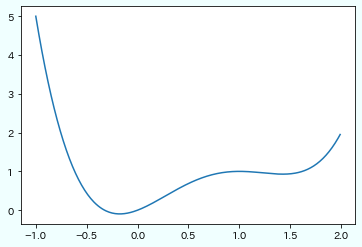

In [3]:
plt.figure(facecolor='azure')
x = np.arange(-1, 2, 0.01)
plt.plot(x, f(x))

## 線形探索
離散的に区間を分割し，一番小さいところを選ぶ
1. 関数を等間隔に細かく区切る
2. 等間隔に区切った値をそれぞれ求める
3. とった値を比較し，最小値を求める

In [4]:
# 等間隔に区切る
def grid_value(L, R, num):
    return list(map(lambda x: [f(x), x],
                    np.linspace(L, R, num=num+1, endpoint=True)))

# 区切った中でf(x)が最小となるxを返す
def min_linear_search(L, R, num):
    return min(grid_value(L, R, num), key=lambda x: x[0])[1]

# 求解
x = min_linear_search(-1, 2, 40)
print(f'x: {x: .3f}, value: {f(x): .3f}')

x: -0.175, value: -0.097


## 最急降下法
坂を下って一番下の点に行く
1. 開始位置を選び，その点の傾きを求める
2. （坂を下る方向に）ステップ幅$\times$傾き分移動する  
  傾きが大きいところでは一気に進んで，小さいところでは少しずつ進む．極値に近づくと傾きが緩やかになっていくので合理的な進み方

x: -0.175, value: -0.097
x:  1.426, value:  0.929
x:  11999999988475.332, value:  20735999920336311102019958993147202285927065255411712.000


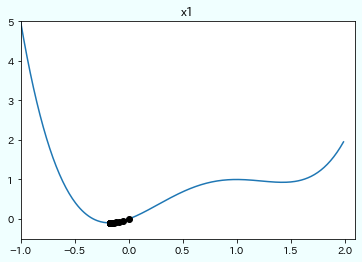

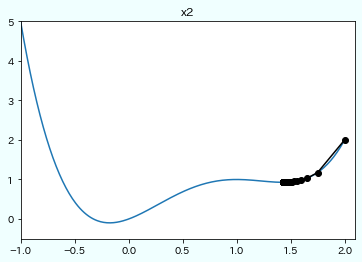

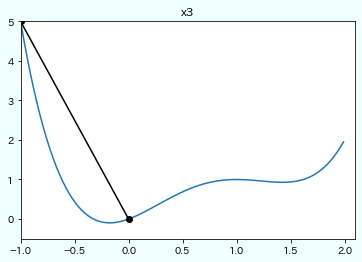

In [25]:
# 右側微分の定義
def differencial(x, EPS=1e-12):
    return (f(x+EPS) - f(x)) / EPS

# 最急降下法
def gradient_descent(alpha, start, steps):
    pos = start
    pos_list = []
    for _ in range(steps):
        pos_list.append(pos)
        # 現在の地点の勾配（傾き）
        grad = differencial(pos)
        # （坂を下る方向に）ステップ幅*傾き分移動する
        pos = pos - alpha * grad
    return pos, pos_list

def drow_path(title, pos_list):
    plt.figure(facecolor='azure')
    plt.xlim([-1, 2.1])
    plt.ylim([-0.5, 5])
    plt.title(f'{title}')
    x = np.arange(-1, 2, 0.01)
    plt.plot(x, f(x))
    plt.plot(pos_list, [f(x) for x in pos_list], color='k', marker='o')

# 求解
x1, pos_list = gradient_descent(0.05, 0, 100)
drow_path('x1', pos_list)

x2, pos_list = gradient_descent(0.05, 2, 100)
drow_path('x2', pos_list)

x3, pos_list = gradient_descent(1, 0, 100)
drow_path('x3', pos_list)

for x in [x1, x2, x3]:
    print(f'x: {x: .3f}, value: {f(x): .3f}')

開始位置が最小値の谷と異なっていたり（x2），ステップ幅が大きすぎると（x3）最適解が得られない．
* x2のように局所最適解に嵌っているケースは乱択アルゴリズムや焼きなまし法を用いて対処する
* x3のようなケースでは，発散させないことと計算結果を早く出すことを両立するために，ステップが進むにつれてステップ幅を小さくする等の対処をする

## 乱択アルゴリズム
複数のランダムな点から最急降下法を行い，一番良い解を採用する
1. ランダムに複数の点を取る
2. 最急降下法を用いて極小値を探す
3. 極小値の中から最小のものを探す

In [25]:
def randomized_algorithm(alpha, L, R, points_num, steps):
    values = []
    # ランダムに点をとり，それぞれに対して最急降下法を適用
    for x in np.random.uniform(L, R, points_num):
        values.append(gradient_descent(alpha, x, steps))
    return min(values)

x = randomized_algorithm(0.05, -1, 2, 10, 100)[0]
print(f'x: {x: .3f}, value: {f(x): .3f}')

x: -0.175, value: -0.097


In [24]:
def randomized_algorithm(alpha, L, R, points_num, steps):
    value = map(lambda x: gradient_descent(alpha, x, steps),
                np.random.uniform(L, R, points_num))
    return min(value)[0]

randomized_algorithm(0.05, -1, 2, 10, 100)

-0.17539189768887342

## $\epsilon$-greedy
近傍からランダムに点を選び，解が改善する or 一定の確率（改悪を許す）で移動する
1. $\epsilon$とある一点を選び，近傍の点をランダムに選ぶ
2. いまより良い解 or $\epsilon$の確率 -> 移動

x: -0.170, value: -0.097


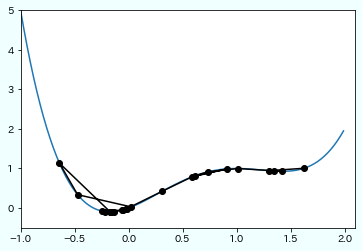

In [77]:
def eps_greedy(alpha, eps, start, points_num, steps):
    global_best_pos = [start, f(start)]
    global_best_path = []
    for _ in range(points_num):
        current_pos = [start, f(start)]
        local_best_pos = current_pos
        local_best_path = []  # 点の軌跡
        for _ in range(steps):
            # 近傍の点をランダムに選択
            diff = alpha * np.random.uniform(-1, 1)
            next_x = current_pos[0] + diff
            next_pos = [next_x, f(next_x)]
            
            # 今より良い解 or 確率eps -> 移動
            p = 0
            if next_pos[1] < current_pos[1]:
                p = 1
            else:
                p = eps         
            if p >= np.random.random():
                current_pos = next_pos
                local_best_path.append(current_pos)
            
            # 解が改善すればbest_posを更新
            if current_pos[1] < local_best_pos[1]:
                local_best_pos = current_pos
                
        if local_best_pos[1] < global_best_pos[1]:
            global_best_pos = local_best_pos
            global_best_path = local_best_path
    return global_best_pos, global_best_path

opt, pos_list = eps_greedy(alpha=0.5, eps=0.1, start=2, points_num=10, steps=50)
pos_list = np.array(pos_list).T
print(f'x: {opt[0]: .3f}, value: {opt[1]: .3f}')

plt.figure(facecolor='azure')
plt.xlim([-1, 2.1])
plt.ylim([-0.5, 5])
x = np.arange(-1, 2, 0.01)
plt.plot(x, f(x))
plt.plot(pos_list[0], pos_list[1], color='k', marker='o')


* 解の改悪を許す設定なので，局所解から脱出できている

## 焼きなまし法
初期段階では比較的ランダムに点を動かし，後期段階に向かうにつれて
1. ある一点を選び，近傍の点をランダムに選ぶ
2. 今より良い解 or 下の確率（$T$が小さくなるにつれて0に近づいていく）で移動  
$\mathrm{e}^{-\frac{\mathrm{value(pos_{n+1})-value(pos_{n})}}{T}}$
3. 現在の温度を冷ます

x: -0.144, value: -0.093


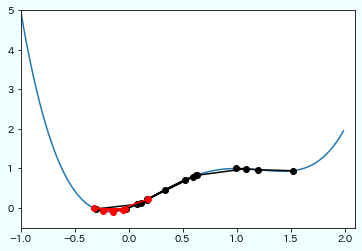

In [53]:
def sa(alpha, T, minT, start, cool):
    current_pos = [start, f(start)]
    best_pos = current_pos
    path = []  # 点の軌跡
    while T > minT:
        # 近傍の点をランダムに選択
        diff = alpha * np.random.uniform(-1, 1)
        next_x = current_pos[0] + diff
        next_pos = [next_x, f(next_x)]

        # 今より良い解 or 上の確率（どんどん小さくなっていく） -> 移動
        p = 0
        if next_pos[1] < current_pos[1]:
            p = 1
        else:
            p = np.exp(-(next_pos[1] - current_pos[1]) / T)         
        if p >= np.random.random():
            current_pos = next_pos
            path.append(current_pos)

        # 解が改善すればbest_posを更新
        if current_pos[1] < best_pos[1]:
            best_pos = current_pos
            
        # 温度を冷ます（Tを小さくする）
        T = T * cool
    return best_pos, path

opt, path = sa(alpha=0.5, T=1e+5, minT=0.01, start=2, cool=0.5)
path = np.array(path).T
print(f'x: {opt[0]: .3f}, value: {opt[1]: .3f}')

plt.figure(facecolor='azure')
plt.xlim([-1, 2.1])
plt.ylim([-0.5, 5])
x = np.arange(-1, 2, 0.01)
plt.plot(x, f(x))

# 前半は黒，後半は赤
milestone = np.int(path.shape[1] * 3 / 4)
plt.plot(path[0][:milestone], path[1][:milestone], color='k', marker='o')
plt.plot(path[0][milestone:], path[1][milestone:], color='red', marker='o')

# 複数のパラメータの最適化

# さらに高度な最適化手法